# Train U-Net for cervix/os detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from datetime import datetime
    
# Project
project_common_path = os.path.abspath(os.path.join('..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Transform `sloth` annotations to label images

In [4]:
from data_utils import type_1_ids, type_2_ids, type_3_ids, test_ids
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations

from image_utils import get_image_data
from image_utils import generate_label_images

In [5]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print(len(annotations))

# generate_label_images(annotations)

639


In [6]:
!ls {GENERATED_DATA}/
ret = !ls {GENERATED_DATA}/trainval_labels_0 | wc -l
print(ret[0])

assert len(annotations) == int(ret[0]), "WTF"

labels
os_cervix_labels_1
templates.csv
trainval_labels_0
unet_os_cervix_detector_seed=54321_lr=0.010000_a=0.875000_stats.npz
unet_os_cervix_detector_stats.npz
     639


## Train and validate

In [7]:
import numpy as np

from training_utils import get_trainval_id_type_lists2
from test_utils import get_test_id_type_list2

from unet_keras_v1 import get_unet

from training_utils import segmentation_train as train, segmentation_validate as validate
from test_utils import segmentation_predict as predict
from xy_providers import DataCache

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


In [8]:
np.random.seed(54321)

In [9]:
train_id_type_list, val_id_type_list = get_trainval_id_type_lists2(annotations=annotations, val_split=0.25)

print "Total : %s, Train : %s, Val : %s" % (len(annotations), len(train_id_type_list), len(val_id_type_list))

print("\n {} - Get U-Net model ...".format(datetime.now()))
unet = get_unet(input_shape=(3, 224, 224), n_classes=2)

Total : 639, Train : 479, Val : 160

 2017-04-02 20:24:57.053430 - Get U-Net model ...


In [10]:
#unet.summary()

Load trained weights

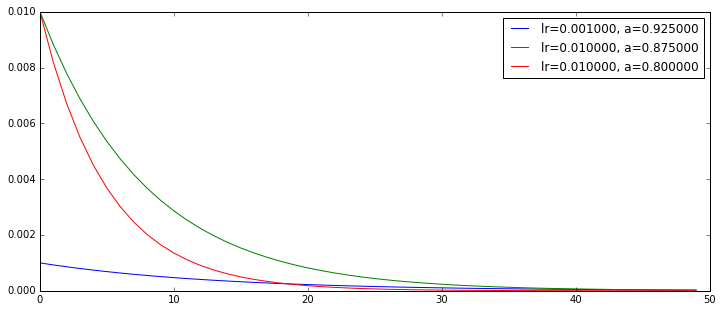

In [13]:
from training_utils import exp_decay

lr_1 = 1e-3; a_1 = 0.925
lr_2 = 1e-2; a_2 = 0.875
lr_3 = 1e-2; a_3 = 0.8

epochs = np.arange(0, 50)
lrs_1 = exp_decay(epochs, lr=lr_1, a=a_1)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
lrs_3 = exp_decay(epochs, lr=lr_3, a=a_3)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.plot(epochs, lrs_3, label="lr=%f, a=%f" % (lr_3, a_3))
plt.legend()

In [27]:
## Load first model:
save_prefix='unet_os_cervix_detector_seed=2017'
## Load second model:
# save_prefix='unet_os_cervix_detector_seed=54321_lr=%.3f_a=%.3f' % (lr_2, a_2)

from glob import glob

weights_files = glob("weights/%s*.h5" % save_prefix)
best_val_loss = 1e5
best_weights_filename = ""
for f in weights_files:
    index = os.path.basename(f).index('-')
    loss = float(os.path.basename(f)[index+1:-4])
    if best_val_loss > loss:
        best_val_loss = loss
        best_weights_filename = f
print("Best val loss weights: ", best_weights_filename)


if len(best_weights_filename) > 0:
    # load weights to the model
    print("Load found weights: ", best_weights_filename)
    unet.load_weights(best_weights_filename)

('Best val loss weights: ', 'weights/unet_os_cervix_detector_seed=2017_42-0.3980.h5')
('Load found weights: ', 'weights/unet_os_cervix_detector_seed=2017_42-0.3980.h5')


In [40]:
if False:
    cache = DataCache(650)
    
    nb_epochs = 10
    batch_size = 4
    
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_3, a=a_3) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(unet, 
              train_id_type_list, 
              val_id_type_list, 
              nb_epochs=nb_epochs,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              save_prefix=save_prefix)


 2017-04-02 12:13:12.340237 - Start training ...
('-- Training parameters: ', 4, 10, 1024, 256)
-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_seed=54321_lr=0.010000_a=0.875000_stats.npz
No need to recompute statistics
-- Fit model
Epoch 1/10
1024/1024 [==============================] - 819s - loss: 0.5367 - jaccard_index: 0.4633 - recall: 0.8406 - precision: 0.7185 - val_loss: 0.4648 - val_jaccard_index: 0.5352 - val_recall: 0.8682 - val_precision: 0.7100
Epoch 2/10
1024/1024 [==============================] - 785s - loss: 0.5153 - jaccard_index: 0.4847 - recall: 0.8469 - precision: 0.7484 - val_loss: 0.4229 - val_jaccard_index: 0.5771 - val_recall: 0.8326 - val_precision: 0.7876
Epoch 3/10
1024/1024 [==============================] - 791s - loss: 0.5089 - jaccard_index: 0.4911 - recall: 0.8551 - precision: 0.7495 - val_loss: 0.4140 - val_jaccard_index: 0.5860 - val_recall: 0.8494 - val_preci

In [13]:
# batch_size = 4
# print("\n {} - Start validation ...".format(datetime.now()))
# validate(unet, val_id_type_list, batch_size=batch_size)


 2017-03-31 18:47:11.181758 - Start validation ...
('--', 4, 'batch jaccard index : ', 0.58127105)
('--', 8, 'batch jaccard index : ', 0.49949092)
('--', 12, 'batch jaccard index : ', 0.63554943)
('--', 16, 'batch jaccard index : ', 0.53554368)
('--', 20, 'batch jaccard index : ', 0.77475148)
('--', 24, 'batch jaccard index : ', 0.53414536)
('--', 28, 'batch jaccard index : ', 0.70723236)
('--', 32, 'batch jaccard index : ', 0.61101305)
('--', 36, 'batch jaccard index : ', 0.64421701)
('--', 40, 'batch jaccard index : ', 0.54392654)
('--', 44, 'batch jaccard index : ', 0.53339297)
('--', 48, 'batch jaccard index : ', 0.52813071)
('--', 52, 'batch jaccard index : ', 0.72948176)
('--', 56, 'batch jaccard index : ', 0.64831638)
('--', 60, 'batch jaccard index : ', 0.62771934)
('--', 64, 'batch jaccard index : ', 0.55069256)
('--', 68, 'batch jaccard index : ', 0.63176632)
('--', 72, 'batch jaccard index : ', 0.61814302)
('--', 76, 'batch jaccard index : ', 0.69151449)
('--', 80, 'batch j

In [10]:
# id_type_list = [val_id_type_list[i] for i in [0, 3, 4, 9, 10, 14, 15, 17]]

In [25]:
from postprocessing_utils import sieve 
from postprocessing_utils import os_cervix_postproc_batch

In [43]:
batch_size = 1
from preprocessing.image.iterators import ImageMaskIterator
from xy_providers import image_mask_provider

train_iter = ImageMaskIterator(image_mask_provider(train_id_type_list, 
                                                   label_type='trainval_label_0', 
                                                   test_mode=True), 
                                  len(train_id_type_list), 
                                  None, # image generator
                                  batch_size=batch_size,
                                  data_format='channels_first')

(1, 3, 224, 224) (1, 2, 224, 224) 1.26546e-27 1.0 [(u'1436', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 0.0 1.0 [(u'804', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 9.40825e-28 1.0 [(u'790', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 0.0 1.0 [(u'581', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 0.0 1.0 [(u'306', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.38892e-26 1.0 [(u'537', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.75517e-22 1.0 [(u'762', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 8.55509e-23 1.0 [(u'1076', u'Type_2')]


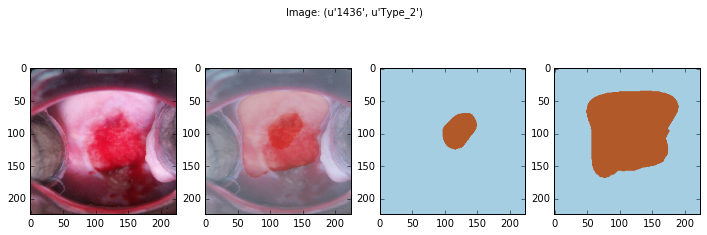

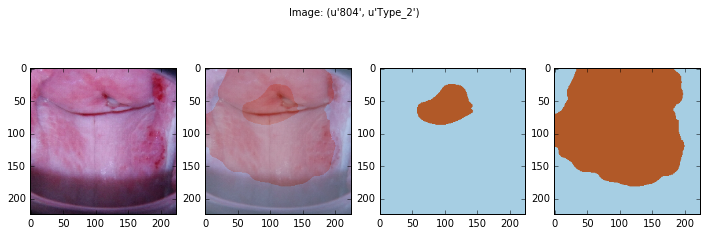

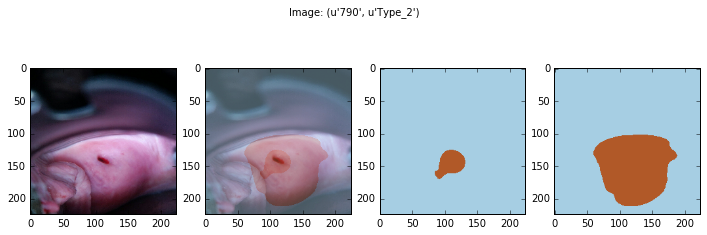

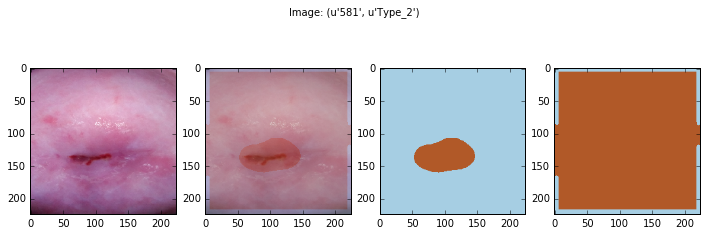

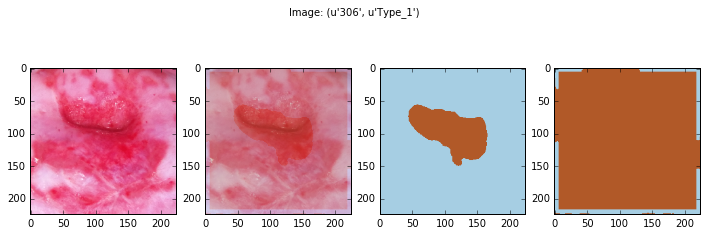

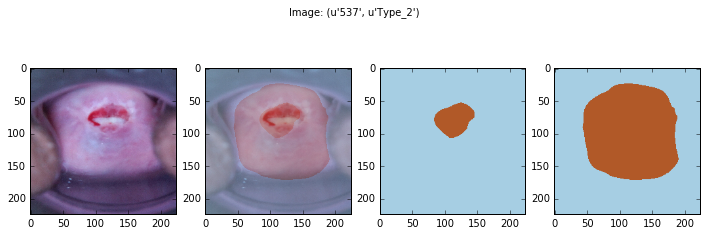

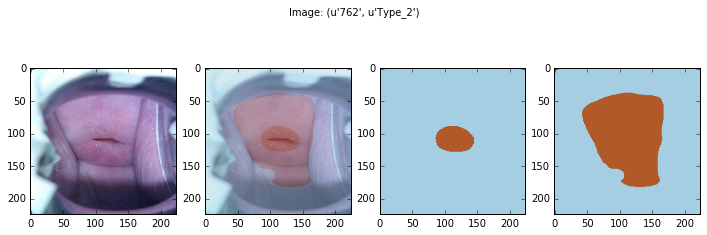

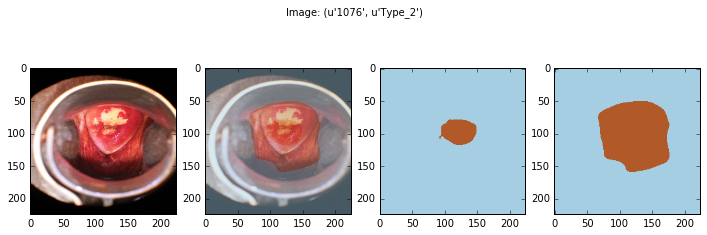

In [47]:
max_counter = 8
n = 2
counter = 0
for x, y_true, info in train_iter:           
    y_pred = unet.predict(x)    
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info 
    
    y_pred = os_cervix_postproc_batch(y_pred)
    
    if False:
        if counter % n == 0:
            plt_st(12, 4)
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.title("Image: {}".format(info[0]))
        
        
    if True:
        if counter % 1 == 0:
            plt_st(12, 4)
        plt.subplot(1, 4, 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.subplot(1, 4, 2)        
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.subplot(1, 4, 3)        
        plt.imshow(y_pred[0, 0, :, :], cmap='Paired') # Os
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred[0, 1, :, :], cmap='Paired') # Cervix
        plt.suptitle("Image: {}".format(info[0]))            
        
    counter += 1
    if counter == max_counter:
        break

In [69]:
batch_size = 1
val_iter = ImageMaskIterator(image_mask_provider(val_id_type_list, test_mode=True), 
                                  len(val_id_type_list), 
                                  None, # image generator
                                  batch_size=batch_size,
                                  data_format='channels_first')

(1, 3, 224, 224) (1, 2, 224, 224) 2.82047e-08 1.0 [(u'408', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 1.57216e-10 1.0 [(u'566', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.33819e-10 1.0 [(u'270', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 1.70347e-11 1.0 [(u'353', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.20738e-10 1.0 [(u'499', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 8.09716e-11 1.0 [(u'1246', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 8.19239e-09 1.0 [(u'490', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.65316e-13 1.0 [(u'55', u'Type_1')]


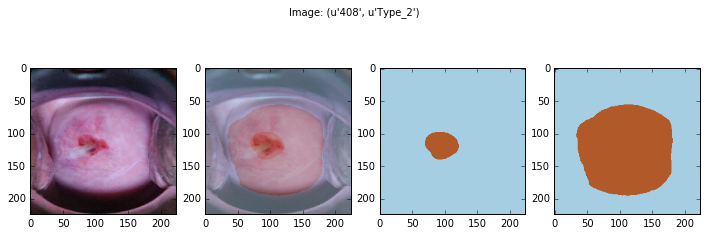

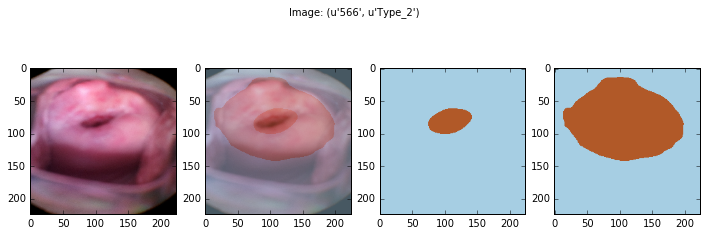

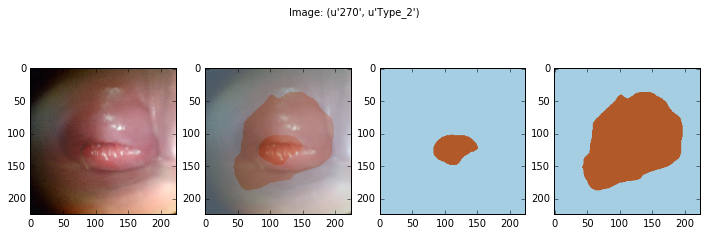

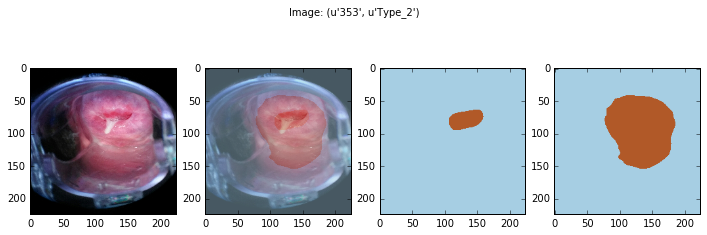

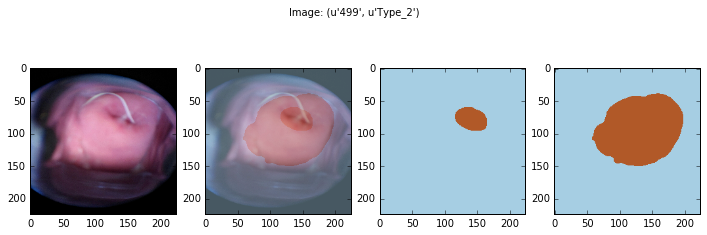

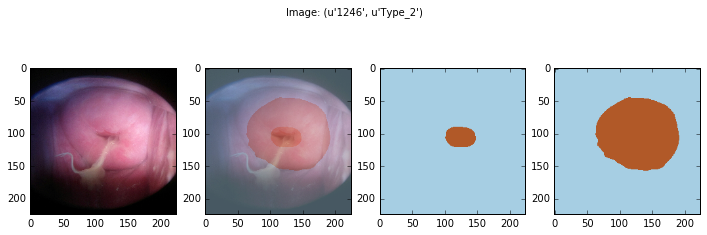

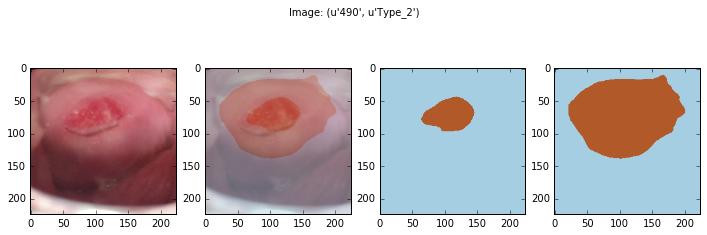

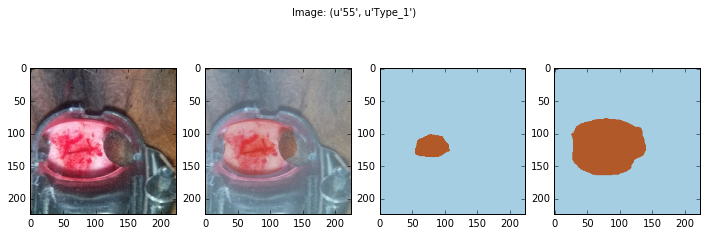

In [71]:
max_counter = 8
n = 2   
counter = 0
for x, y_true, info in val_iter:           
    y_pred = unet.predict(x)
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info
    
    y_pred = os_cervix_postproc_batch(y_pred)
    
    if False:
        if counter % n == 0:
            plt_st(12, 4)
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.title("Image: {}".format(info[0]))
        
        
    if True:
        if counter % 1 == 0:
            plt_st(12, 4)
        plt.subplot(1, 4, 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.subplot(1, 4, 2)        
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.subplot(1, 4, 3)        
        plt.imshow(y_pred[0, 0, :, :], cmap='Paired') # Os
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred[0, 1, :, :], cmap='Paired') # Cervix
        plt.suptitle("Image: {}".format(info[0]))                      
    counter += 1
    if counter == max_counter:
        break

In [106]:
!ls {GENERATED_DATA}/

labels                            trainval_labels
os_cervix_stats.npz               trainval_labels_0
templates.csv                     unet_os_cervix_detector_stats.npz


## Compute and store predictions for all trainval dataset

In [20]:
from training_utils import get_trainval_id_type_lists
from xy_providers import image_provider
from image_utils import imwrite
from preprocessing.image.iterators import ImageMaskIterator

In [16]:
type_ids = [type_1_ids, type_2_ids, type_3_ids]
image_types = ["Type_1", "Type_2", "Type_3"]
all_trainval_id_type_list = []
for ids, image_type in zip(type_ids, image_types):
    for image_id in ids:
        all_trainval_id_type_list.append((image_id, image_type))

In [17]:
len(all_trainval_id_type_list)

1481

In [28]:
batch_size = 4
all_trainval_iter = ImageMaskIterator(image_provider(all_trainval_id_type_list), 
                                  len(all_trainval_id_type_list), 
                                  None, # image generator
                                  batch_size=batch_size,
                                  data_format='channels_first')

In [29]:
counter = 1
ll = len(all_trainval_id_type_list)
for x, _, info in all_trainval_iter:               
    y_pred = unet.predict(x)   
#     try:
#         y_pred = os_cervix_postproc(y_pred)
#     except Exception as e:
#         print e
#         for i in range(x.shape[0]):
#             plt_st(12, 6)
#             plt.subplot(1, 4, 1)
#             plt.imshow(x[i, :, :, :].transpose([1, 2, 0]))
#             plt.subplot(1, 4, 2)        
#             plt.imshow(x[i, :, :, :].transpose([1, 2, 0]))
#             plt.imshow(y_pred[i, 0, :, :], alpha=0.25, cmap='Paired') # Os
#             plt.imshow(y_pred[i, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
#             plt.subplot(1, 4, 3)        
#             plt.imshow(y_pred[i, 0, :, :], cmap='Paired') # Os
#             plt.subplot(1, 4, 4)
#             plt.imshow(y_pred[i, 1, :, :], cmap='Paired') # Cervix
#             plt.suptitle("Image: {}".format(info[i]))      
#         break
    
    for i in range(y_pred.shape[0]):
        print('-- %i / %i : %s, %s' % (counter, ll, info[i][0], info[i][1]))        
        image_id = info[i][0] + '_' + info[i][1]
        imwrite(y_pred[i, :, :, :], image_id, 'os_servix_label_1')
        counter += 1

-- 1 / 1481 : 0, Type_1
-- 2 / 1481 : 10, Type_1
-- 3 / 1481 : 1013, Type_1
-- 4 / 1481 : 1014, Type_1


## Compute final labels from previous predictions

- Compare masks
- Compute a weighted sum of mask
- Post-processing

In [37]:
import cv2 
from postprocessing_utils import os_cervix_postproc

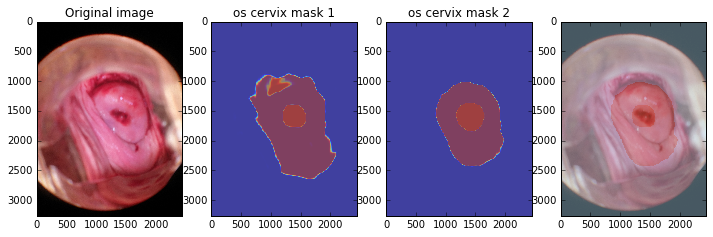

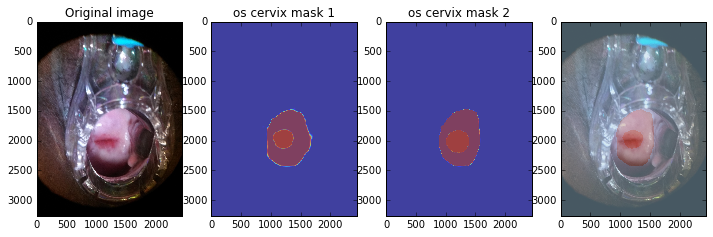

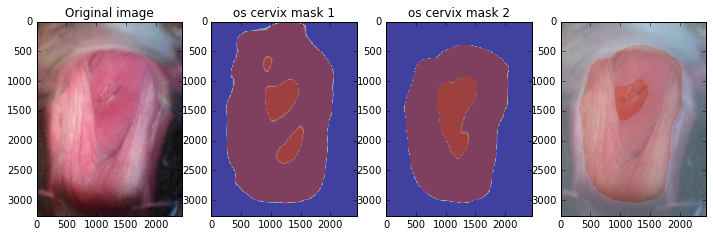

In [41]:
n = 1
image_type = 'Type_1'
id_type_list = []
for ids, image_type in zip(type_ids, image_types):
    for image_id in ids[:n]:
        id_type_list.append((image_id, image_type))

def _resize(mask, size):
    mask = cv2.resize(mask, dsize=size, interpolation=cv2.INTER_NEAREST)
    return mask

for image_id, image_type in id_type_list:

    img = get_image_data(image_id, image_type)
    os_cervix_mask_1 = get_image_data(image_id + "_" + image_type, 'os_cervix_label_1').transpose([1, 2, 0])
    os_cervix_mask_2 = get_image_data(image_id + "_" + image_type, 'os_cervix_label_2').transpose([1, 2, 0])
    final_os_cervix_mask = 0.45 * os_cervix_mask_1 + 0.55 * os_cervix_mask_2
    final_os_cervix_mask = os_cervix_postproc(final_os_cervix_mask)
    
    os_cervix_mask_1 = _resize(os_cervix_mask_1, img.shape[:2][::-1])
    os_cervix_mask_2 = _resize(os_cervix_mask_2, img.shape[:2][::-1])
    final_os_cervix_mask = _resize(final_os_cervix_mask, img.shape[:2][::-1])
    
    plt_st(12, 6)
    plt.subplot(141)
    plt.imshow(img)
    plt.title("Original image")
    plt.subplot(142)
    plt.imshow(os_cervix_mask_1[:,:,0], alpha=0.5, cmap='jet')    
    plt.imshow(os_cervix_mask_1[:,:,1], alpha=0.5, cmap='jet')
    plt.title("os cervix mask 1")
    plt.subplot(143)
    plt.imshow(os_cervix_mask_2[:,:,0], alpha=0.5, cmap='jet')
    plt.imshow(os_cervix_mask_2[:,:,1], alpha=0.5, cmap='jet')
    plt.title("os cervix mask 2")
    plt.subplot(144)
    plt.imshow(img)
    plt.imshow(final_os_cervix_mask[:,:,0], alpha=0.25, cmap='Paired')
    plt.imshow(final_os_cervix_mask[:,:,1], alpha=0.25, cmap='Paired')